# Save CSVs

In [5]:
import sys
sys.path.insert(1, '../../functions')
import importlib
import numpy as np
import nbformat
import plotly.express
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization
import food_bank_functions
import food_bank_bayesian
from food_bank_functions import *
from food_bank_bayesian import *
importlib.reload(food_bank_functions)

<module 'food_bank_functions' from '../../functions\\food_bank_functions.py'>

In [6]:
opt_policy = np.loadtxt('../../data/gaussian/opt_policy_mean_15_var_3.csv', delimiter=",")
vals = np.loadtxt('../../data/gaussian/vals_15_var_3.csv', delimiter=",")
support = np.loadtxt('../../data/gaussian/support_15_var_3.csv', delimiter=",")

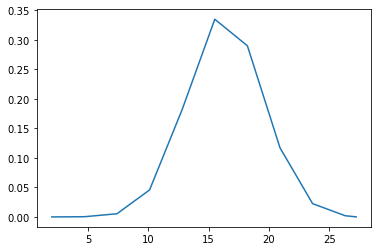

In [7]:
plt.plot(support, vals)

# Experiments

## Varying Number of Groups

In [8]:
num_iterations = 200
max_n = 100000
grid_size = .01

# need to replicate the distributions down in an array of dimension n
sorted_distribution = np.asarray([support for i in range(max_n)])
weights = np.asarray([vals for i in range(max_n)])


max_budget = max_n*15
b_grid = np.arange(0, max_budget+grid_size, grid_size)

In [9]:
len(b_grid)

150000001

In [10]:
opt_policy.shape

(100, 150001)

In [11]:
np.random.choice(size=50, a=support, p=vals)

array([20.9, 15.5, 12.8, 15.5, 20.9, 15.5, 18.2, 18.2, 18.2, 12.8, 18.2,
       15.5, 18.2, 12.8, 15.5, 18.2, 18.2, 12.8, 15.5, 12.8, 15.5, 15.5,
       18.2, 12.8, 15.5, 15.5, 15.5, 23.6, 20.9, 18.2, 15.5, 12.8, 18.2,
       15.5, 12.8, 15.5, 18.2, 15.5, 18.2, 20.9, 12.8, 18.2, 18.2, 18.2,
       18.2, 20.9, 20.9, 18.2, 18.2, 15.5])

In [12]:
expected_demand = 15

### L1 Norm between OPT and ALGs

In [ ]:
data_dict_1 = {'NumGroups':[],'Dynamic':[],'Weights':[], 'Bayes':[], 'Threshold':[],'Greedy':[]}
for n in np.logspace(0,5,num_iterations):
    n = max(int(n),1)
    group_expected_demands = np.zeros(n) + 15    
    budget = n*15
    for i in range(num_iterations):
        data_dict_1['NumGroups'].append(n)
        group_demands = np.random.choice(size=n, a=support, p=vals)
        opt = waterfilling_waste(group_demands,budget)
        data_dict_1['Weights'].append(np.sum(np.absolute(opt - waterfilling_weights_waste(weights[0:n], sorted_distribution[0:n], group_demands, budget))))
        data_dict_1['Dynamic'].append(np.sum(np.absolute(opt - waterfilling_dynamic_waste(group_expected_demands,group_demands,budget))))
        data_dict_1['Bayes'].append(np.sum(np.absolute(opt - waterfilling_proportional_remaining(group_demands, budget))))
        data_dict_1['Greedy'].append(np.sum(np.absolute(opt - greedy(group_demands,budget))))
        data_dict_1['Threshold'].append(np.sum(np.absolute(opt - constant_threshold(group_demands,budget,expected_demand))))                                                  
df_uniform = pd.DataFrame(data_dict_1).melt(id_vars="NumGroups")
df_uniform.to_csv('../../data/gaussian/L1_test.csv')
fig = px.scatter(df_uniform, x="NumGroups", y="value", color='variable')
fig.update_layout(xaxis_type="log", yaxis_type="log")
fig.update_layout(
    title="L1 Distance between OPT and ALGs",
    xaxis_title="Number of Groups",
    yaxis_title="Distance")
fig.show()

### L-Inf Norm between OPT and ALGs

In [ ]:
data_dict_1 = {'NumGroups':[],'Dynamic':[],'Weights':[], 'Bayes':[], 'Threshold':[],'Greedy':[]}

for n in np.logspace(0,5,num_iterations):
    n = max(int(n),1)
    group_expected_demands = np.zeros(n) + 15    
    budget = n*15
    for i in range(num_iterations):
        data_dict_1['NumGroups'].append(n)
        group_demands = np.random.choice(size=n, a=support, p=vals)
        opt = waterfilling_waste(group_demands,budget)
        data_dict_1['Weights'].append(np.amax(np.absolute(opt - waterfilling_weights_waste(weights[0:n], sorted_distribution[0:n], group_demands, budget))))
        data_dict_1['Dynamic'].append(np.amax(np.absolute(opt - waterfilling_dynamic_waste(group_expected_demands,group_demands,budget))))
        data_dict_1['Bayes'].append(np.amax(np.absolute(opt - waterfilling_proportional_remaining(group_demands, budget))))
        data_dict_1['Greedy'].append(np.amax(np.absolute(opt - greedy(group_demands,budget))))
        data_dict_1['Threshold'].append(np.amax(np.absolute(opt - constant_threshold(group_demands,budget,expected_demand))))
df_uniform = pd.DataFrame(data_dict_1).melt(id_vars="NumGroups")
df_uniform.to_csv('../../data/simple_distribution/L-Inf.csv')
fig = px.scatter(df_uniform, x="NumGroups", y="value", color='variable')
fig.update_layout(xaxis_type="log", yaxis_type="log")
fig.update_layout(
    title="L-Inf Distance between OPT and ALGs",
    xaxis_title="Number of Groups",
    yaxis_title="Distance")
fig.show()

## Constant Number of Groups: Group by Group Comparison

In [9]:
num_iterations = 1000
grid_size = .01
n=20

## Fairness Comparisons using Utility

In [12]:
group = np.arange(n)
budget = .9*15*n
group_expected_demands = np.zeros(n) + 15
score_weights = np.zeros((n,num_iterations))
score_bayes = np.zeros((n,num_iterations))
score_dynamic = np.zeros((n,num_iterations))
score_greedy = np.zeros((n,num_iterations))
score_threshold = np.zeros((n,num_iterations))
env = np.zeros((5,num_iterations))
po = np.zeros((5,num_iterations))
prop = np.zeros((5,num_iterations))
linf = np.zeros((5, num_iterations))
for i in range(num_iterations):
    group_demands = np.random.choice(size=n, a=support, p=vals)
    opt = waterfilling_waste(group_demands,budget)
    bayes = waterfilling_bayesian(group_demands, opt_policy[(max_n-n):(max_n+1),:], budget, b_grid, grid_size)
    
    # comparing the Bayes algorithm
    score_bayes[:,i] = opt - bayes
    env[0,i] = max(0,np.amax(envy_utility(bayes,group_demands)))
    po[0,i] = excess(bayes,budget)
    prop[0,i] = np.amax(proportionality_utility(bayes,group_demands,budget))
    linf[0,i] = np.amax(score_bayes[:,i])
    
    # comparing exp-demand
    weights_alloc = waterfilling_weights_waste(weights, sorted_distribution, group_demands,budget)
    score_weights[:,i] = opt - weights_alloc
    env[1,i] = max(0,np.amax(envy_utility(weights_alloc,group_demands)))
    po[1,i] = excess(weights_alloc,budget)
    prop[1,i] = np.amax(proportionality_utility(weights_alloc,group_demands,budget))
    linf[1,i] = np.amax(score_weights[:,i])
    
    # comparing exp-number
    dynamic = waterfilling_dynamic_waste(group_expected_demands,group_demands,budget)
    score_dynamic[:,i] = opt - dynamic
    env[2,i] = max(0,np.amax(envy_utility(dynamic,group_demands)))
    po[2,i] = excess(dynamic,budget)
    prop[2,i] = np.amax(proportionality_utility(dynamic,group_demands,budget))
    linf[2,i] = np.amax(score_dynamic[:,i])
    
    # comparing greedy
    greedy_alloc = greedy(group_demands,budget)
    score_greedy[:,i] = opt - greedy_alloc
    env[3,i] = max(0,np.amax(envy_utility(greedy_alloc,group_demands)))
    po[3,i] = excess(greedy_alloc,budget)
    prop[3,i] = np.amax(proportionality_utility(greedy_alloc,group_demands,budget))
    linf[3,i] = np.amax(score_greedy[:,i])
    
    # comparing threshold
    threshold = constant_threshold(group_demands,budget,expected_demand)
    score_threshold[:,i] = opt - threshold
    env[4,i] = max(0,np.amax(envy_utility(threshold,group_demands)))
    po[4,i] = excess(threshold,budget)
    prop[4,i] = np.amax(proportionality_utility(threshold,group_demands,budget))
    linf[4,i] = np.amax(score_threshold[:,i])
score_bayes = np.average(score_bayes, axis=1)
score_weights = np.average(score_weights, axis=1)
score_dynamic = np.average(score_dynamic, axis=1)
score_greedy = np.average(score_greedy, axis=1)
score_threshold = np.average(score_threshold, axis=1)
env = np.average(env,axis=1)
po = np.average(po,axis=1)
prop = np.average(prop,axis=1)
linf = np.average(linf,axis=1)
print('bayes, weights, dynamic, greedy, threshold')
print('envy:')
print(env)
print('po')
print(po)
print('prop')
print(prop)
print('linf')
print(linf)
data_dict = {'Group':group,'Dynamic':score_dynamic,'Weights':score_weights, 'Bayes':score_bayes, 'Threshold':score_threshold,'Greedy':score_greedy}
df_uniform = pd.DataFrame(data_dict).melt(id_vars="Group")
df_uniform.to_csv('../../data/gaussian/GroupAllocationDifference.csv')
fig = px.scatter(df_uniform, x="Group", y="value", color='variable')
fig.update_layout(
    title="Group by Group Allocation Difference between OPT and ALGs",
    xaxis_title="Group",
    yaxis_title="Difference")
fig.show()

bayes, weights, dynamic, greedy, threshold
envy:
[0.93208856 0.0668835  0.08021696 0.99961062 0.80622373]
po
[-5.68434189e-16  2.69955214e-02  4.72094217e-02 -2.07478479e-16
  1.18500000e-03]
prop
[0.82279804 0.01147717 0.         0.92798379 0.7407852 ]
linf
[12.69084889  0.54789367  0.4219923  13.88112695 12.05974918]


In [13]:
print('bayes, weights, dynamic, greedy, threshold')
print('envy:')
print(env)
print('po')
print(po)
print('prop')
print(prop)
print('linf')
print(linf)
print('sum of measures')
print(env+po+prop)

bayes, weights, dynamic, greedy, threshold
envy:
[0.93208856 0.0668835  0.08021696 0.99961062 0.80622373]
po
[-5.68434189e-16  2.69955214e-02  4.72094217e-02 -2.07478479e-16
  1.18500000e-03]
prop
[0.82279804 0.01147717 0.         0.92798379 0.7407852 ]
linf
[12.69084889  0.54789367  0.4219923  13.88112695 12.05974918]
sum of measures
[1.7548866  0.10535619 0.12742638 1.92759441 1.54819393]
